In [1]:
#!/bin/bash
!kaggle datasets download paultimothymooney/chest-xray-pneumonia

Dataset URL: https://www.kaggle.com/datasets/paultimothymooney/chest-xray-pneumonia
License(s): other
 99%|██████████████████████████████████████▊| 2.28G/2.29G [00:08<00:00, 269MB/s]
100%|███████████████████████████████████████| 2.29G/2.29G [00:08<00:00, 292MB/s]


In [2]:
import zipfile
import os

# Specify the path to the zip file
zip_file_path = '/kaggle/working/chest-xray-pneumonia.zip'
extract_to_path = '.'

# Create the directory if it doesn't exist
os.makedirs(extract_to_path, exist_ok=True)

# Extract the zip file
with zipfile.ZipFile(zip_file_path, 'r') as zip_ref:
    zip_ref.extractall(extract_to_path)

print(f"Files extracted to {extract_to_path}")

Files extracted to .


In [3]:
import torch
from torch.utils.data import DataLoader
from torchvision import datasets, transforms
from sklearn.model_selection import train_test_split
import os

In [4]:
import torch
from torch.utils.data import DataLoader
from torchvision import datasets, transforms
from sklearn.model_selection import train_test_split
import os

# Directory paths for the dataset
train_data_dir = '/kaggle/working/chest_xray/train'
test_data_dir = '/kaggle/working/chest_xray/test'
val_data_dir = '/kaggle/working/chest_xray/val'

imagenet_mean = [0.485, 0.456, 0.406]
imagenet_std = [0.229, 0.224, 0.225]

# Preprocessing: Resize, Normalize
transform = transforms.Compose([
    transforms.Resize((224, 224)),
    transforms.Grayscale(num_output_channels=3), 
    transforms.ToTensor(),
    transforms.transforms.Normalize(
                    mean=[-m / s for m, s in zip(imagenet_mean, imagenet_std)],
                    std=[1 / s for s in imagenet_std]
                ) 
])


val_dataset = datasets.ImageFolder(root=val_data_dir, transform=transform)
test_dataset = datasets.ImageFolder(root=test_data_dir, transform=transform)

val_loader = DataLoader(val_dataset, batch_size=32, shuffle=False)
test_loader = DataLoader(test_dataset, batch_size=32, shuffle=False)

In [5]:
imagenet_mean = [0.485, 0.456, 0.406]
imagenet_std = [0.229, 0.224, 0.225]

augmented_transform = transforms.Compose([
    transforms.RandomRotation(30),
    transforms.RandomHorizontalFlip(),
    transforms.RandomResizedCrop(224),
    transforms.Grayscale(num_output_channels=3),
    transforms.ToTensor(),
    transforms.transforms.Normalize(
                    mean=[-m / s for m, s in zip(imagenet_mean, imagenet_std)],
                    std=[1 / s for s in imagenet_std]
                )  # ImageNet stats
])

# Apply augmentation only to the training dataset
train_augmented_data = datasets.ImageFolder(root=train_data_dir, transform=augmented_transform)
train_augmented_loader = DataLoader(train_augmented_data, batch_size=32, shuffle=True)


In [6]:
images, labels = next(iter(train_augmented_loader))
print(f"Image tensor shape: {images.shape}")  # e.g., [32, 3, 224, 224]
print(f"Pixel value range: {images.min()} to {images.max()}")  # Should show 0.0 to 1.0

Image tensor shape: torch.Size([32, 3, 224, 224])
Pixel value range: 0.4059999883174896 to 0.7131019830703735


In [7]:
import torch.nn as nn
import torchvision.models as models

# Load the pre-trained MobileNetV2 model
model = models.mobilenet_v2(pretrained=True)

# Freeze the pre-trained layers (except the last layer)
for param in model.parameters():
    param.requires_grad = True

model.classifier[1] = nn.Linear(model.classifier[1].in_features, 2)  # 2 output classes: Normal, Pneumonia

/usr/local/lib/python3.10/dist-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=MobileNet_V2_Weights.IMAGENET1K_V1`. You can also use `weights=MobileNet_V2_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)
Downloading: "https://download.pytorch.org/models/mobilenet_v2-b0353104.pth" to /root/.cache/torch/hub/checkpoints/mobilenet_v2-b0353104.pth
100%|██████████| 13.6M/13.6M [00:00<00:00, 106MB/s] 


In [8]:
import torch
import torch.nn as nn
import torch.nn.functional as F

class PneumoniaNN(nn.Module):
    def __init__(self, input_channels=3, num_classes=2):
        super(PneumoniaNN, self).__init__()
        # Convolutional Layers with BatchNorm and Dropout
        self.conv1 = nn.Conv2d(input_channels, 32, kernel_size=3, stride=1, padding=1)
        self.bn1 = nn.BatchNorm2d(32)
        self.conv2 = nn.Conv2d(32, 64, kernel_size=3, stride=1, padding=1)
        self.bn2 = nn.BatchNorm2d(64)
        self.conv3 = nn.Conv2d(64, 128, kernel_size=3, stride=1, padding=1)
        self.bn3 = nn.BatchNorm2d(128)
        
        # Fully Connected Layers
        self.fc1 = nn.Linear(100352, 512)  # Adjust input size based on your image dimensions
        self.fc2 = nn.Linear(512, num_classes)
        
        self.dropout = nn.Dropout(0.5)
        self.pool = nn.MaxPool2d(kernel_size=2, stride=2)

    def forward(self, x):
        x = self.pool(F.relu(self.bn1(self.conv1(x))))
        x = self.pool(F.relu(self.bn2(self.conv2(x))))
        x = self.pool(F.relu(self.bn3(self.conv3(x))))
        x = torch.flatten(x, 1)
        x = F.relu(self.fc1(x))
        x = self.dropout(x)
        x = self.fc2(x)
        return x

In [9]:
import torch
import torch.nn as nn
import torch.optim as optim
import tqdm
import numpy as np

# EarlyStopping class
class EarlyStopping:
    def __init__(self, patience=5, delta=0.001, path='best_model.pth', verbose=False):
        """
        Args:
            patience (int): How long to wait after the last improvement.
            delta (float): Minimum change in the monitored quantity to qualify as an improvement.
            path (str): Path to save the best model.
            verbose (bool): Whether to print updates about early stopping.
        """
        self.patience = patience
        self.delta = delta
        self.best_loss = np.inf
        self.counter = 0
        self.early_stop = False
        self.path = path
        self.verbose = verbose

    def __call__(self, val_loss, model):
        if val_loss < self.best_loss - self.delta:
            self.best_loss = val_loss
            self.counter = 0
            self.save_checkpoint(model)
        else:
            self.counter += 1
            if self.verbose:
                print(f"EarlyStopping counter: {self.counter} out of {self.patience}")
            if self.counter >= self.patience:
                self.early_stop = True

    def save_checkpoint(self, model):
        """Saves the model when validation loss improves."""
        torch.save(model.state_dict(), self.path)
        if self.verbose:
            print("Validation loss decreased. Saving model...")

# Training function
def train(model, train_loader, val_loader, num_epochs, learning_rate, patience=5):
    """
    Trains the model with early stopping.
    
    Args:
        model (torch.nn.Module): The CNN model to train.
        train_loader (DataLoader): DataLoader for training data.
        val_loader (DataLoader): DataLoader for validation data.
        num_epochs (int): Number of epochs to train for.
        learning_rate (float): Learning rate for the optimizer.
        patience (int): Patience for early stopping.
    """
    # Loss function
    criterion = nn.CrossEntropyLoss()

    # Optimizer
    optimizer = optim.Adam(model.parameters(), lr=learning_rate, weight_decay=1e-4)

    # Early stopping
    early_stopping = EarlyStopping(patience=patience, verbose=True)

    # Device configuration
    device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
    model = model.to(device)

    for epoch in range(num_epochs):
        # Training phase
        model.train()
        progress_bar = tqdm.tqdm(train_loader, desc=f"Epoch {epoch + 1}/{num_epochs}", leave=True)

        running_loss = 0.0
        correct_preds = 0
        total_preds = 0

        for inputs, labels in progress_bar:
            inputs, labels = inputs.to(device), labels.to(device)

            # Zero gradients
            optimizer.zero_grad()

            # Forward pass
            outputs = model(inputs)
            loss = criterion(outputs, labels)

            # Backward pass and optimization
            loss.backward()
            optimizer.step()

            # Track metrics
            running_loss += loss.item()
            _, predicted = torch.max(outputs, 1)
            correct_preds += (predicted == labels).sum().item()
            total_preds += labels.size(0)

            progress_bar.set_description(f"Epoch {epoch + 1}/{num_epochs}, Loss: {loss.item():.4f}")

        train_loss = running_loss / len(train_loader)
        train_accuracy = 100 * correct_preds / total_preds

        # Validation phase
        model.eval()
        val_loss = 0.0
        correct_preds = 0
        total_preds = 0

        with torch.no_grad():
            for inputs, labels in val_loader:
                inputs, labels = inputs.to(device), labels.to(device)
                outputs = model(inputs)
                loss = criterion(outputs, labels)
                val_loss += loss.item()
                _, predicted = torch.max(outputs, 1)
                correct_preds += (predicted == labels).sum().item()
                total_preds += labels.size(0)

        val_loss /= len(val_loader)
        val_accuracy = 100 * correct_preds / total_preds

        print(f"Epoch {epoch+1}/{num_epochs}, Train Loss: {train_loss:.4f}, Train Acc: {train_accuracy:.2f}%, Val Loss: {val_loss:.4f}, Val Acc: {val_accuracy:.2f}%")

        # Early stopping
        early_stopping(val_loss, model)
        if early_stopping.early_stop:
            print("Early stopping triggered!")
            break

    # Load the best model
    model.load_state_dict(torch.load(early_stopping.path))
    print("Training complete. Best model restored.")
    return model


In [10]:
# Move model to GPU if available
import torch

try:
    import torch_xla.core.xla_model as xm
    device = xm.xla_device()  # Automatically detects TPU if available
except ImportError:
    device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')



In [11]:
# net = PneumoniaCNN(input_size=(3, 224, 224))


best_model = train(model, train_augmented_loader, test_loader, num_epochs=20, learning_rate=1e-3, patience=5)

Epoch 1/20, Loss: 0.2022: 100%|██████████| 163/163 [02:00<00:00,  1.36it/s]


Epoch 1/20, Train Loss: 0.2871, Train Acc: 88.17%, Val Loss: 0.3853, Val Acc: 84.29%
Validation loss decreased. Saving model...


Epoch 2/20, Loss: 0.2785: 100%|██████████| 163/163 [01:57<00:00,  1.38it/s]


Epoch 2/20, Train Loss: 0.2097, Train Acc: 91.60%, Val Loss: 0.2111, Val Acc: 91.35%
Validation loss decreased. Saving model...


Epoch 3/20, Loss: 0.0999: 100%|██████████| 163/163 [01:58<00:00,  1.37it/s]


Epoch 3/20, Train Loss: 0.1941, Train Acc: 92.58%, Val Loss: 0.9361, Val Acc: 64.74%
EarlyStopping counter: 1 out of 5


Epoch 4/20, Loss: 0.2280: 100%|██████████| 163/163 [01:59<00:00,  1.36it/s]


Epoch 4/20, Train Loss: 0.1905, Train Acc: 92.18%, Val Loss: 0.2268, Val Acc: 90.71%
EarlyStopping counter: 2 out of 5


Epoch 5/20, Loss: 0.2588: 100%|██████████| 163/163 [02:01<00:00,  1.34it/s]


Epoch 5/20, Train Loss: 0.1923, Train Acc: 92.47%, Val Loss: 0.3088, Val Acc: 88.94%
EarlyStopping counter: 3 out of 5


Epoch 6/20, Loss: 0.2861: 100%|██████████| 163/163 [02:00<00:00,  1.35it/s]


Epoch 6/20, Train Loss: 0.1620, Train Acc: 94.04%, Val Loss: 0.2348, Val Acc: 90.54%
EarlyStopping counter: 4 out of 5


Epoch 7/20, Loss: 0.1573: 100%|██████████| 163/163 [02:00<00:00,  1.35it/s]


Epoch 7/20, Train Loss: 0.1631, Train Acc: 93.19%, Val Loss: 0.3207, Val Acc: 87.50%
EarlyStopping counter: 5 out of 5
Early stopping triggered!
Training complete. Best model restored.


<ipython-input-9-fba7f7d26820>:131: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  model.load_state_dict(torch.load(early_stopping.path))


In [12]:
# torch.save(best_model, 'pre_train.pth')

In [13]:
import torch.nn.functional as F
net = PneumoniaNN()

custom_best_model = train(net, train_augmented_loader, test_loader, num_epochs=10, learning_rate=1e-3, patience=5)

Epoch 1/10, Loss: 0.3353: 100%|██████████| 163/163 [01:52<00:00,  1.44it/s]


Epoch 1/10, Train Loss: 2.0530, Train Acc: 76.42%, Val Loss: 1.2822, Val Acc: 39.10%
Validation loss decreased. Saving model...


Epoch 2/10, Loss: 0.2230: 100%|██████████| 163/163 [01:53<00:00,  1.43it/s]


Epoch 2/10, Train Loss: 0.3820, Train Acc: 82.67%, Val Loss: 0.5287, Val Acc: 75.16%
Validation loss decreased. Saving model...


Epoch 3/10, Loss: 0.2873: 100%|██████████| 163/163 [01:53<00:00,  1.43it/s]


Epoch 3/10, Train Loss: 0.3805, Train Acc: 82.07%, Val Loss: 1.3809, Val Acc: 41.19%
EarlyStopping counter: 1 out of 5


Epoch 4/10, Loss: 0.3052: 100%|██████████| 163/163 [01:53<00:00,  1.44it/s]


Epoch 4/10, Train Loss: 0.3700, Train Acc: 83.45%, Val Loss: 3.0322, Val Acc: 37.50%
EarlyStopping counter: 2 out of 5


Epoch 5/10, Loss: 0.3680: 100%|██████████| 163/163 [01:54<00:00,  1.43it/s]


Epoch 5/10, Train Loss: 0.3652, Train Acc: 81.79%, Val Loss: 1.2608, Val Acc: 38.78%
EarlyStopping counter: 3 out of 5


Epoch 6/10, Loss: 0.4029: 100%|██████████| 163/163 [01:52<00:00,  1.44it/s]


Epoch 6/10, Train Loss: 0.3789, Train Acc: 81.63%, Val Loss: 0.6871, Val Acc: 40.22%
EarlyStopping counter: 4 out of 5


Epoch 7/10, Loss: 0.3547: 100%|██████████| 163/163 [01:52<00:00,  1.44it/s]


Epoch 7/10, Train Loss: 0.3797, Train Acc: 81.90%, Val Loss: 0.5576, Val Acc: 70.35%
EarlyStopping counter: 5 out of 5
Early stopping triggered!


<ipython-input-9-fba7f7d26820>:131: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  model.load_state_dict(torch.load(early_stopping.path))


Training complete. Best model restored.


In [14]:
# torch.save(custom_best_model, 'max.pth')

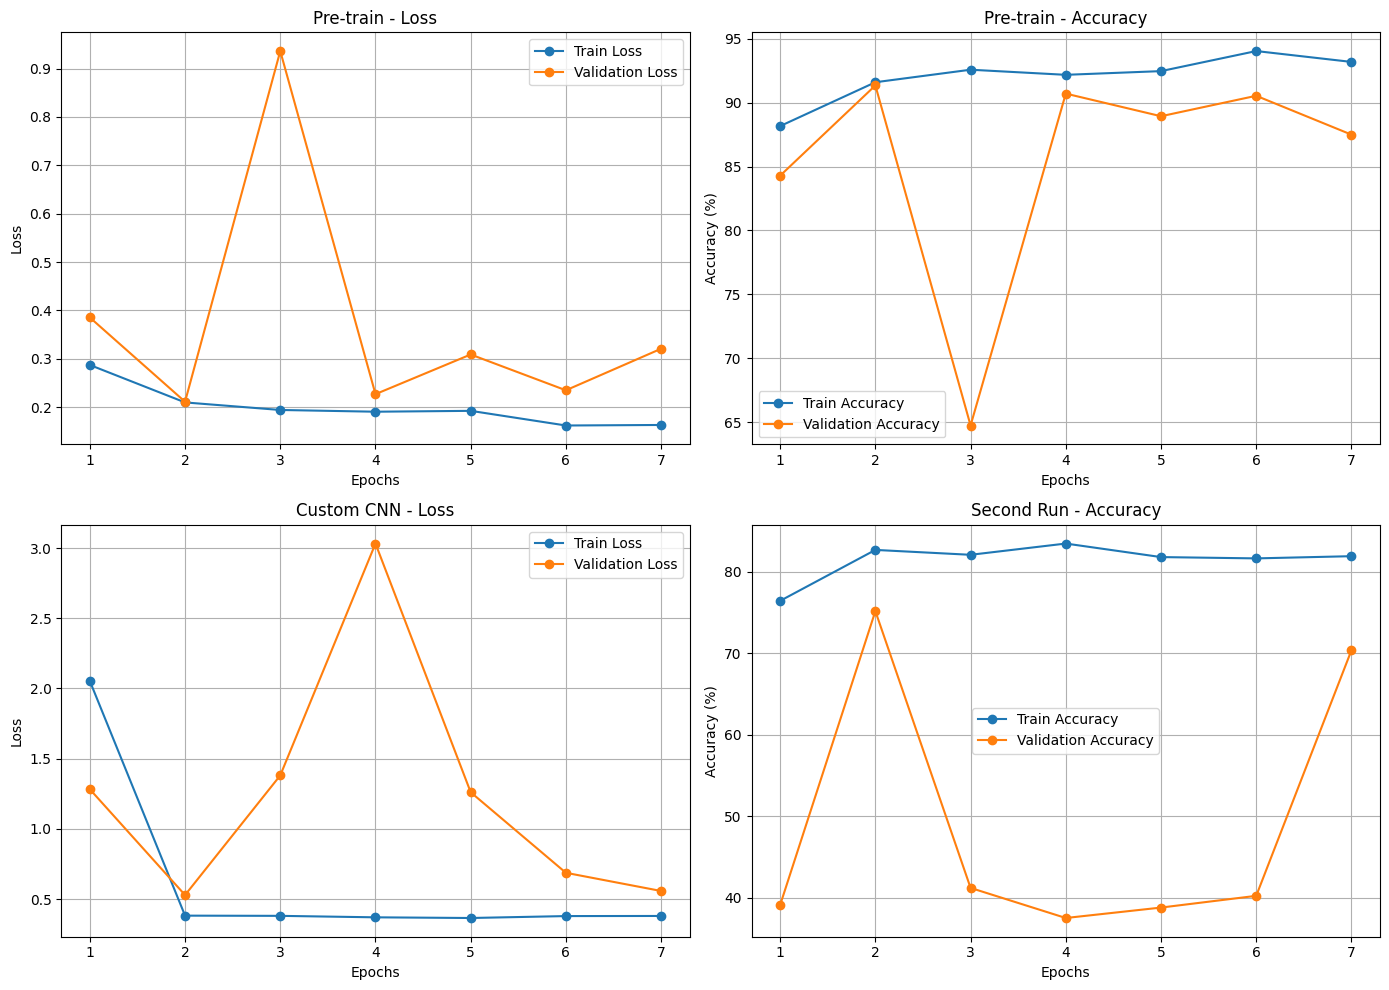

In [23]:
import matplotlib.pyplot as plt

# Data for plotting
epochs_1 = list(range(1, 8))  # Epochs for the first run
train_loss_1 = [0.2871, 0.2097, 0.1941, 0.1905, 0.1923, 0.1620, 0.1631]
val_loss_1 = [0.3853, 0.2111, 0.9361, 0.2268, 0.3088, 0.2348, 0.3207]
train_acc_1 = [88.17, 91.60, 92.58, 92.18, 92.47, 94.04, 93.19]
val_acc_1 = [84.29, 91.35, 64.74, 90.71, 88.94, 90.54, 87.50]

epochs_2 = list(range(1, 8))  # Epochs for the second run
train_loss_2 = [2.0530, 0.3820, 0.3805, 0.3700, 0.3652, 0.3789, 0.3797]
val_loss_2 = [1.2822, 0.5287, 1.3809, 3.0322, 1.2608, 0.6871, 0.5576]
train_acc_2 = [76.42, 82.67, 82.07, 83.45, 81.79, 81.63, 81.90]
val_acc_2 = [39.10, 75.16, 41.19, 37.50, 38.78, 40.22, 70.35]

# Plot
fig, axes = plt.subplots(2, 2, figsize=(14, 10))

# First Run - Loss
axes[0, 0].plot(epochs_1, train_loss_1, label="Train Loss", marker='o')
axes[0, 0].plot(epochs_1, val_loss_1, label="Validation Loss", marker='o')
axes[0, 0].set_title("Pre-train - Loss")
axes[0, 0].set_xlabel("Epochs")
axes[0, 0].set_ylabel("Loss")
axes[0, 0].legend()
axes[0, 0].grid()

# First Run - Accuracy
axes[0, 1].plot(epochs_1, train_acc_1, label="Train Accuracy", marker='o')
axes[0, 1].plot(epochs_1, val_acc_1, label="Validation Accuracy", marker='o')
axes[0, 1].set_title("Pre-train - Accuracy")
axes[0, 1].set_xlabel("Epochs")
axes[0, 1].set_ylabel("Accuracy (%)")
axes[0, 1].legend()
axes[0, 1].grid()

# Second Run - Loss
axes[1, 0].plot(epochs_2, train_loss_2, label="Train Loss", marker='o')
axes[1, 0].plot(epochs_2, val_loss_2, label="Validation Loss", marker='o')
axes[1, 0].set_title("Custom CNN - Loss")
axes[1, 0].set_xlabel("Epochs")
axes[1, 0].set_ylabel("Loss")
axes[1, 0].legend()
axes[1, 0].grid()

# Second Run - Accuracy
axes[1, 1].plot(epochs_2, train_acc_2, label="Train Accuracy", marker='o')
axes[1, 1].plot(epochs_2, val_acc_2, label="Validation Accuracy", marker='o')
axes[1, 1].set_title("Second Run - Accuracy")
axes[1, 1].set_xlabel("Epochs")
axes[1, 1].set_ylabel("Accuracy (%)")
axes[1, 1].legend()
axes[1, 1].grid()

plt.tight_layout()
plt.show()


In [19]:
def evaluate_test_accuracy(model, test_loader):
    device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
    model = model.to(device)  # Move model to device
    model.eval()  # Set model to evaluation mode

    correct_preds = 0
    total_preds = 0

    with torch.no_grad():  # Disable gradient calculation
        for inputs, labels in test_loader:
            inputs, labels = inputs.to(device), labels.to(device)

            # Forward pass
            outputs = model(inputs)

            # Get predicted class
            _, predicted = torch.max(outputs, 1)

            # Update correct predictions and total samples
            correct_preds += (predicted == labels).sum().item()
            total_preds += labels.size(0)

    # Calculate accuracy
    test_accuracy = 100 * correct_preds / total_preds
    print(f"Test Accuracy: {test_accuracy:.2f}%")
    return test_accuracy


# Example Usage:
# Assuming `test_loader` is your DataLoader for test data and `best_model` is the trained model
test_accuracy = evaluate_test_accuracy(best_model, test_loader)
test_accuracy = evaluate_test_accuracy(custom_best_model, test_loader)


Test Accuracy: 91.35%
Test Accuracy: 75.16%


In [20]:
test_dir='/kaggle/working/chest_xray/test/NORMAL'
from skimage.io import imread
from PIL import Image
import glob
image_list = []
for filename in glob.glob(test_dir+'/*.jpeg'):
    #im=Image.open(filename)
    image_list.append(filename)

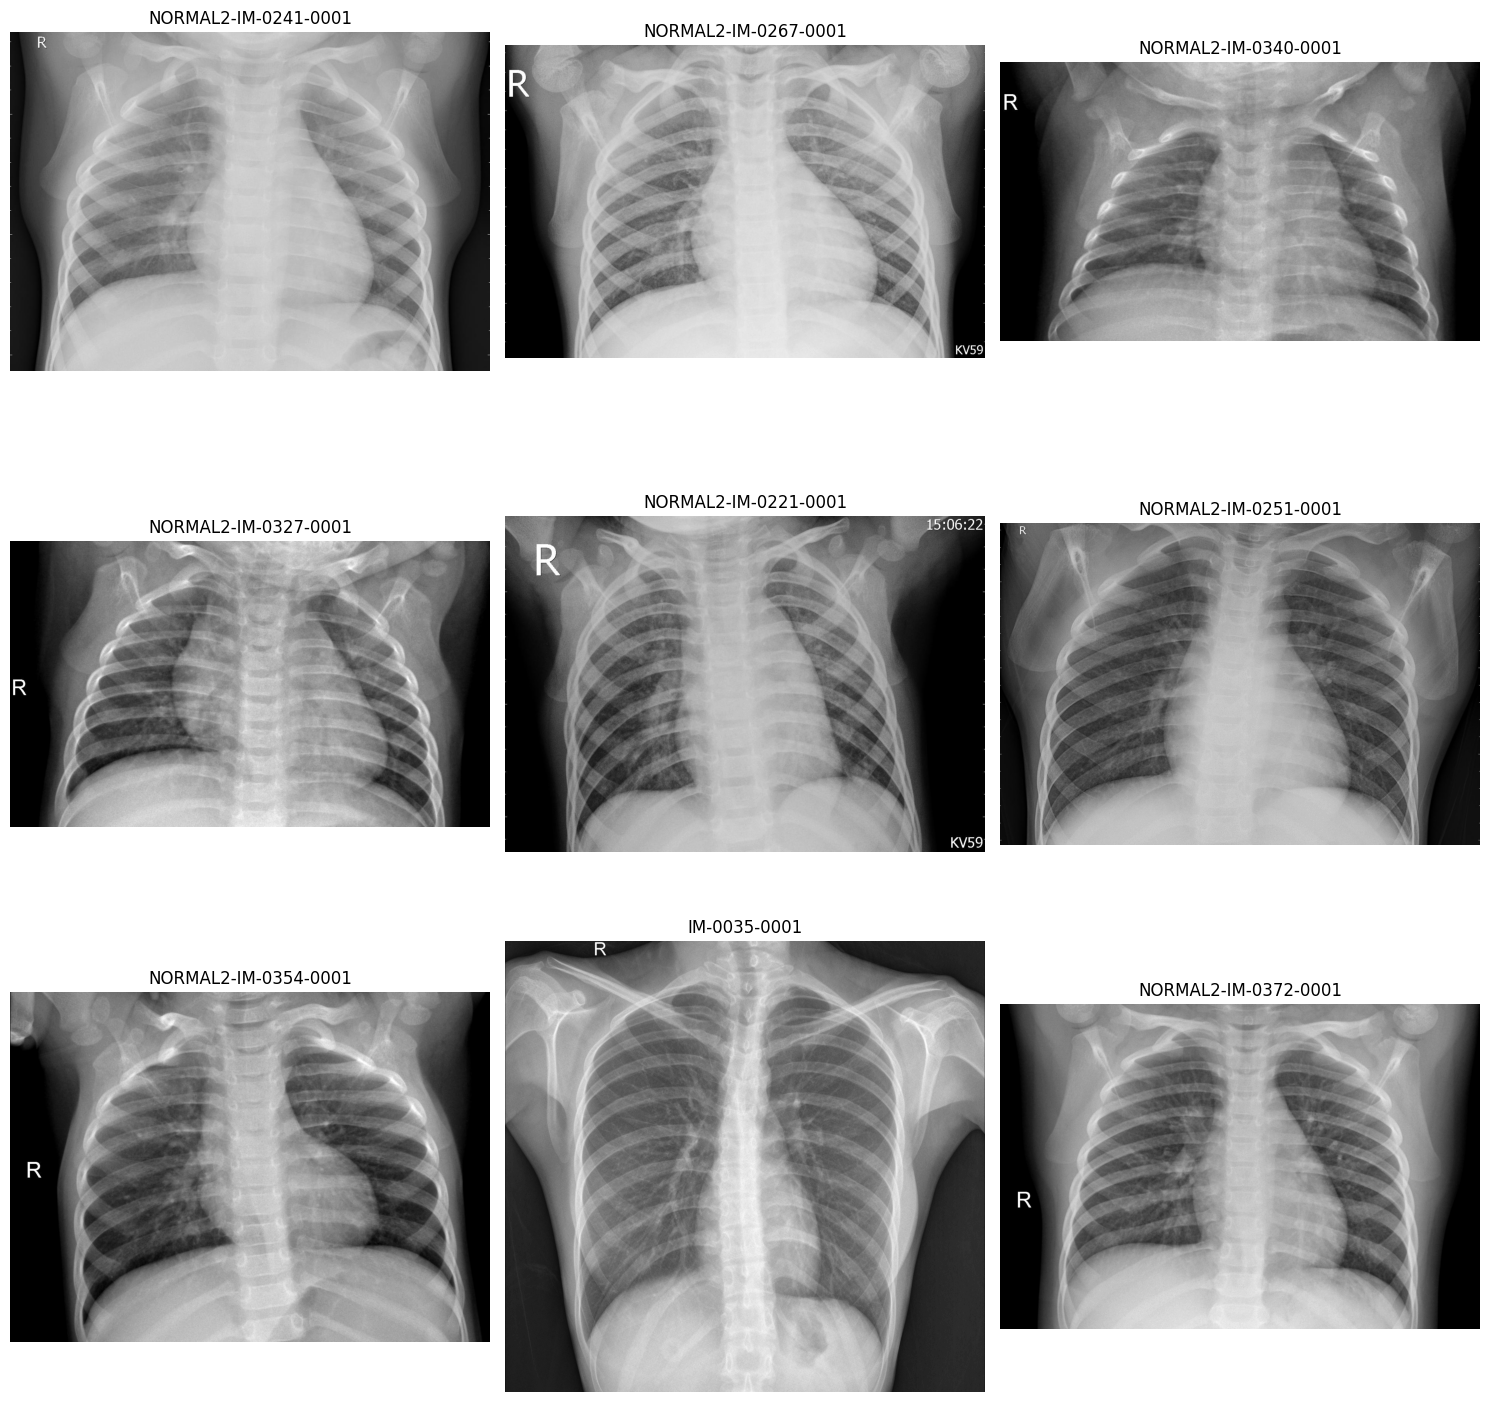

In [21]:
import matplotlib.pyplot as plt
from matplotlib.image import imread
import math

def plot_input(image_list):
    num_images = len(image_list)
    grid_size = math.ceil(math.sqrt(num_images))  # Determine grid size dynamically
    fig, ax = plt.subplots(grid_size, grid_size, figsize=(15, 15))  # Adjust figure size
    ax = ax.flatten()  # Flatten the axes array for easy indexing

    for i in range(len(image_list)):
        img = imread(image_list[i])
        name = image_list[i].split("/")[-1].split(".")[0]
        ax[i].imshow(img, cmap='gray')  # Show the image
        ax[i].set_title(name, fontsize=12)  # Set the title for each image
        ax[i].axis('off')  # Hide axes for a cleaner look

    # Hide unused subplots (if any)
    for i in range(len(image_list), len(ax)):
        ax[i].axis('off')

    plt.tight_layout()
    plt.show()

# Example usage
plot_input(image_list[:9])


In [24]:
import torch.nn.functional as F

class GradCAM:
    def __init__(self, model, target_layer):
        self.model = model
        self.target_layer = target_layer
        self.gradients = None
        self.activations = None

        # Register hooks
        target_layer.register_forward_hook(self.save_activation)
        target_layer.register_full_backward_hook(self.save_gradient)

    def save_activation(self, module, input, output):
        self.activations = output

    def save_gradient(self, module, grad_input, grad_output):
        self.gradients = grad_output[0]

    def __call__(self, x, class_idx=None):
        # Forward pass
        self.model.eval()
        output = self.model(x)

        if class_idx is None:
            class_idx = output.argmax(dim=1)

        # Zero gradients
        self.model.zero_grad()

        # Target for backprop
        one_hot = torch.zeros_like(output)
        one_hot[0][class_idx] = 1

        # Backward pass
        output.backward(gradient=one_hot, retain_graph=True)

        # Global average pooling of gradients
        weights = torch.mean(self.gradients, dim=(2, 3))

        # Weight the activations
        cam = torch.zeros(self.activations.shape[2:], device=self.activations.device)
        for i, w in enumerate(weights[0]):
            cam += w * self.activations[0, i]

        # Apply ReLU and normalize
        cam = F.relu(cam)
        cam = cam - torch.min(cam)
        cam = cam / torch.max(cam)

        return cam.detach()

def visualize_cam(image, cam):
    # Convert PIL Image to numpy array
    if isinstance(image, Image.Image):
        image_np = np.array(image)
    else:
        image_np = image

    # Convert CAM to numpy array if it isn't already
    if torch.is_tensor(cam):
        cam = cam.cpu().numpy()

    # Normalize CAM to 0-1 range if needed
    if cam.max() > 1:
        cam = (cam - cam.min()) / (cam.max() - cam.min())

    # Ensure cam is the same size as the input image
    cam_resized = cv2.resize(cam, (image_np.shape[1], image_np.shape[0]))

    # Create heatmap
    heatmap = cv2.applyColorMap(np.uint8(255 * cam_resized), cv2.COLORMAP_JET)

    # Convert RGB to BGR if necessary (OpenCV uses BGR)
    if len(image_np.shape) == 3 and image_np.shape[2] == 3:
        image_np = cv2.cvtColor(image_np, cv2.COLOR_RGB2BGR)

    # Ensure both images have the same number of channels
    if len(image_np.shape) != len(heatmap.shape):
        if len(image_np.shape) == 2:
            image_np = cv2.cvtColor(image_np, cv2.COLOR_GRAY2BGR)

    # Now combine them
    result = cv2.addWeighted(image_np, 0.7, heatmap, 0.7, 5)

    return result

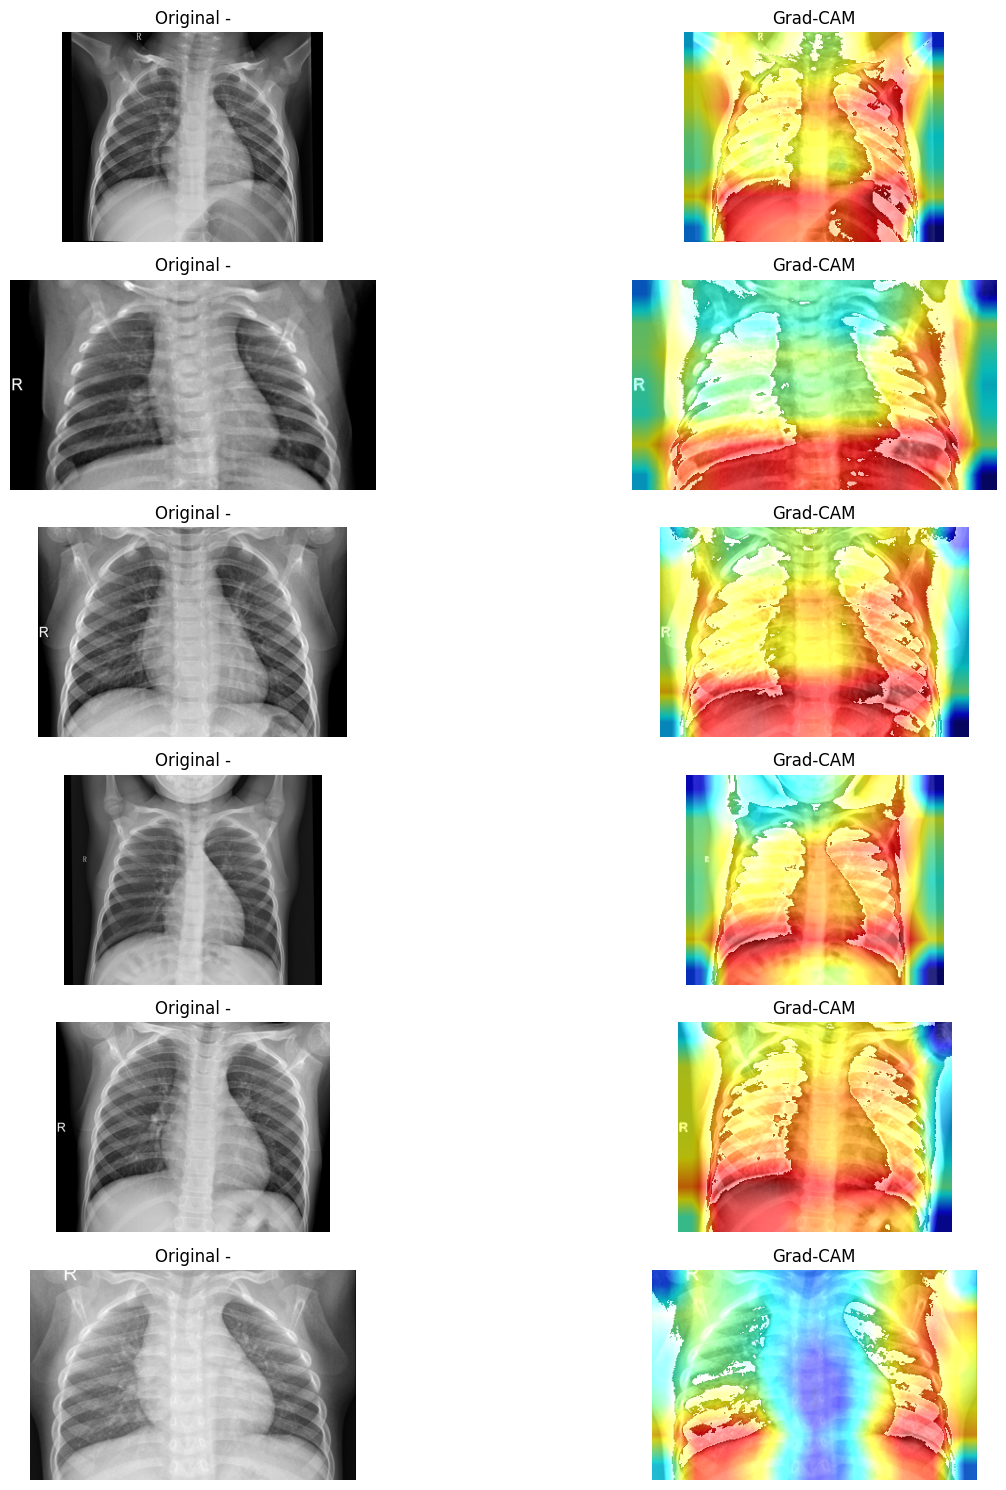

In [38]:
import random

plt.figure(figsize=(15, 15))
num_samples = 6
random_img_paths = random.sample(image_list, num_samples)

for idx, path in enumerate(random_img_paths):
    # Load and preprocess image
    pil_image = Image.open(path).convert('RGB')


    # Define transforms

    transform = transforms.Compose([
            transforms.Resize(224),
            transforms.Grayscale(num_output_channels=3),  
            transforms.ToTensor(),
            transforms.Normalize([0.5,0.5,0.5],[0.5,0.5,0.5]),
    ])

    # Transform and add batch dimension

    input_tensor = transform(pil_image).unsqueeze(0)

    # Move everything to GPU if available

    device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
    model = best_model.to(device)
    target_layer = model.features[-1]
    grad_cam = GradCAM(model, target_layer)
    input_tensor = input_tensor.to(device)
    # Generate CAM
    cam = grad_cam(input_tensor)
    # Visualize
    input_image = transforms.ToPILImage()(input_tensor.squeeze(0).cpu())
    result = visualize_cam(input_image, cam)

     # Plot original and Grad-CAM
    plt.subplot(num_samples, 2, 2*idx + 1)
    plt.imshow(pil_image)
    plt.title(f'Original -')
    plt.axis('off')

    plt.subplot(num_samples, 2, 2*idx + 2)
    plt.imshow(cv2.cvtColor(result, cv2.COLOR_BGR2RGB))
    plt.title('Grad-CAM')
    plt.axis('off')

plt.tight_layout()
plt.show()


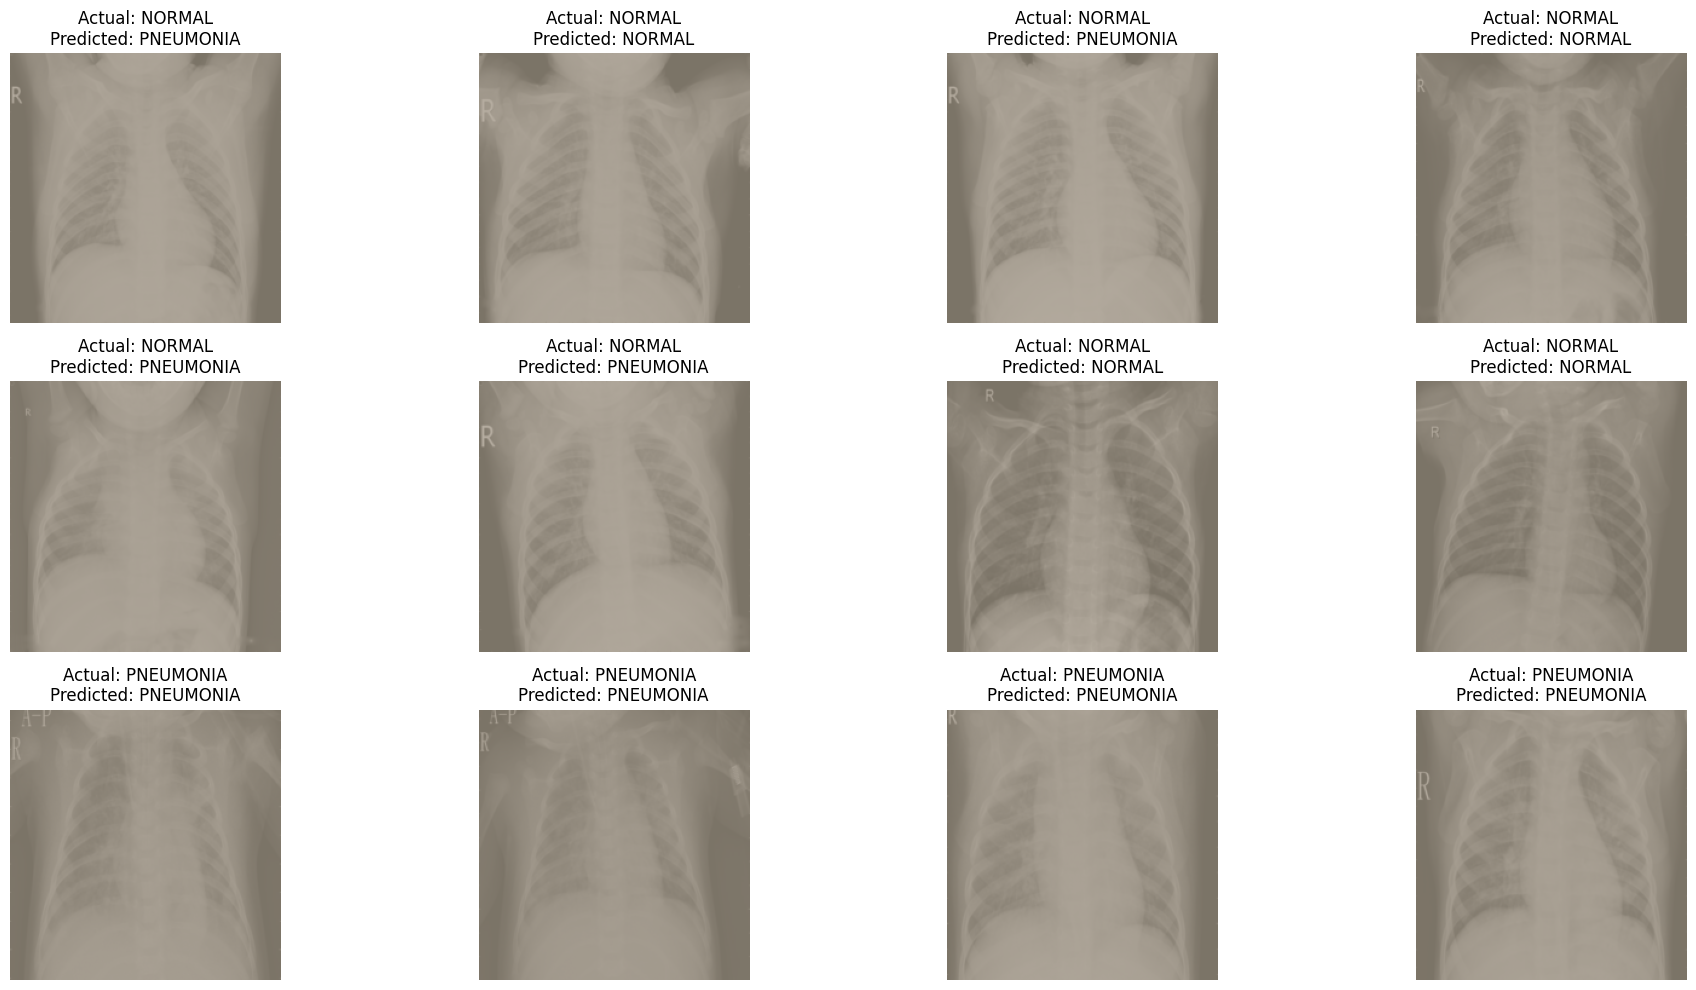

In [41]:
import torch
import matplotlib.pyplot as plt
from torchvision import transforms
from PIL import Image

def visualize_predictions_from_loader(val_loader, model, class_names, transform=None):
    """
    Predict and display the first 8 images from the validation loader with their predicted and actual labels.

    Args:
        val_loader (DataLoader): DataLoader for validation dataset.
        model (torch.nn.Module): Trained PyTorch model for prediction.
        class_names (list): List of class names corresponding to class indices.
        transform (callable): Transformations to apply to the images before prediction.
    """
    # Create a grid for visualization
    fig, ax = plt.subplots(3, 4, figsize=(20, 10))  # 2 rows, 4 columns
    ax = ax.flatten()

    # Ensure the model is in evaluation mode
    model.eval()

    # Move model to GPU if available
    device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
    model = model.to(device)

    # Get the first batch of data from the validation loader
    with torch.no_grad():
        for i, (images, labels) in enumerate(val_loader):
            if i == 0:  # Only take the first batch
                break

        # Make sure we only use the first 8 images
        images = images[:12]
        labels = labels[:12]

        # Send the images and labels to the same device as the model
        images, labels = images.to(device), labels.to(device)

        # Make predictions
        outputs = model(images)
        _, predicted_labels = torch.max(outputs, 1)

        # Convert tensors to CPU and numpy for display
        images = images.cpu()
        predicted_labels = predicted_labels.cpu()
        labels = labels.cpu()

        # Display the images with actual and predicted labels
        for i in range(12):
            img = images[i].cpu().numpy().transpose((1, 2, 0))  # Convert to HWC format
            ax[i].imshow(img)
            ax[i].axis('off')  # Hide axes for a cleaner look
            ax[i].set_title(
                f"Actual: {class_names[labels[i]]}\nPredicted: {class_names[predicted_labels[i]]}",
                fontsize=12
            )

    plt.tight_layout()
    plt.show()

# Example usage
class_names = ['NORMAL', 'PNEUMONIA']

# Assuming `val_loader` is your validation data loader
visualize_predictions_from_loader(val_loader, best_model, class_names)


In [52]:
!pip install torchviz

In [ ]:
from torchviz import make_dot
from torchsummary import summary

def archit(model):
    summary(model, (3, 224, 224))
    dummy_input = torch.randn(16, 3, 224, 224).to(device) 
    
    output = net(dummy_input).to(device)
    
    dot = make_dot(output, params=dict(net.named_parameters()))
    
    dot.render("model_architecture1", format="png") 
    dot.view()

archit(best_model)
archit(custom_best_model)